# Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## Importing the libraries.

In [93]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook as tqdm
import os
from pathlib import Path

from bs4 import BeautifulSoup
from prettytable import PrettyTable

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import math
from sklearn.metrics import make_scorer

### Helper function to read the pickle files

In [74]:
def read_file(file):
    infile = open(file,'rb')
    data = pickle.load(infile)
    infile.close()
    return data

In [75]:
y_train, y_cv, y_test = read_file('tmp/y_train'), read_file('tmp/y_cv'), read_file('tmp/y_test')

In [76]:
X_train_bow, X_cv_bow, X_test_bow = read_file('tmp/bagow')
X_train_bigram, X_cv_bigram, X_test_bigram = read_file('tmp/bigram')
X_train_tfidf, X_cv_tfidf, X_test_tfidf = read_file('tmp/tfidf')
sent_vectors_train, sent_vectors_cv, sent_vectors_test = read_file('tmp/avgw2v')
tfidf_sent_vectors_train, tfidf_sent_vectors_cv, tfidf_sent_vectors_test = read_file('tmp/w2vtfidf')


In [77]:
count_vect_bow = read_file('tmp/count_vect_bow')
count_vect_bigram = read_file('tmp/count_vect_bigram')
tf_idf_vect = read_file('tmp/tf_idf_vect')
w2v_words = read_file('tmp/w2v_words')

In [94]:
param_grid = {'max_depth': [3,4,5,6], 'criterion': ['gini', 'entropy']}
clf = DecisionTreeClassifier()
grid = GridSearchCV(clf, param_grid, cv=3, refit=True, return_train_score=True, scoring=make_scorer(roc_auc_score))
grid.fit(X_train_bow, y_train)



GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 5, 6], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score), verbose=0)

In [95]:
grid.cv_results_['params'], grid.cv_results_['mean_test_score'], grid.cv_results_['mean_train_score']

([{'criterion': 'gini', 'max_depth': 3},
  {'criterion': 'gini', 'max_depth': 4},
  {'criterion': 'gini', 'max_depth': 5},
  {'criterion': 'gini', 'max_depth': 6},
  {'criterion': 'entropy', 'max_depth': 3},
  {'criterion': 'entropy', 'max_depth': 4},
  {'criterion': 'entropy', 'max_depth': 5},
  {'criterion': 'entropy', 'max_depth': 6}],
 array([0.51627737, 0.52558488, 0.53034867, 0.54156949, 0.50236264,
        0.5050722 , 0.5130317 , 0.53227271]),
 array([0.51726194, 0.52800027, 0.53510432, 0.55126791, 0.50308736,
        0.50701888, 0.5192701 , 0.5420304 ]))

In [106]:
grid.best_estimator_.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

### Building Model and testing

In [113]:
def cross_validate_model(X_train, X_cv, y_train, y_cv):
    alpha = np.array([3,4,5,6,7,8,9,10])
    auc_train = []
    auc_cv = []
    for a in alpha:
        clf = DecisionTreeClassifier(max_depth=a, criterion='gini')
        clf.fit(X_train, y_train)
        prob = clf.predict_proba(X_cv)[:,1]
        auc_cv.append(roc_auc_score(y_cv, prob))
        probtr=clf.predict_proba(X_train)[:,1]
        auc_train.append(roc_auc_score(y_train,probtr))
    optimal_alpha= alpha[np.argmax(auc_cv)] 
    alpha=[math.log(x) for x in alpha]#converting values of alpha into logarithm
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(alpha, auc_train, label='AUC train')
    ax.plot(alpha, auc_cv, label='AUC CV')
    plt.title('AUC vs hyperparameter')
    plt.xlabel('alpha')
    plt.ylabel('AUC')
    ax.legend()
    plt.show()
    print('optimal alpha for which auc is maximum : ',optimal_alpha)
    
    return optimal_alpha


def train_model(X_train, X_test, y_train, y_test, optimal_alpha):
    clf = DecisionTreeClassifier(max_depth=optimal_alpha, criterion='gini')
    clf.fit(X_train, y_train)
    predi=clf.predict_proba(X_test)[:,1]
    fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
    pred=clf.predict_proba(X_train)[:,1]
    fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
    ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
    plt.title('ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    ax.legend()
    plt.show()
    return clf
    
def test_model(clf, X_test, y_test):
    pred = clf.predict(X_test)
    conf = confusion_matrix(y_test, pred)
    label = ['negetive', 'positive']
    df = pd.DataFrame(conf, index=label, columns=label)
    sns.heatmap(df, annot=True, fmt='d')
    plt.title("Confusion Matrix for test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
def main_features(all_features, X_train, y_train, optimal_alpha):
    model = DecisionTreeClassifier(max_depth=optimal_alpha, criterion='gini')
    model.fit(X_train, y_train)
    weight=model.feature_importances_
    pos_indx=np.argsort(weight)

    neg_indx=np.argsort(weight)[::-1]
    top_features = []
    worst_features = []
    for i in list(pos_indx[0:10]):
        top_features.append(all_features[i])

    for i in list(neg_indx[0:10]):
        worst_features.append(all_features[i])
    return ' '.join(top_features),  ' '.join(worst_features)
        
def build_word_cloud(features):
    wordcloud = WordCloud().generate(features)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def train_test_model(X_train, X_cv, X_test, y_train, y_cv, y_test, all_features):
    optimal_alpha = cross_validate_model(X_train, X_cv, y_train, y_cv)
    clf = train_model(X_train, X_test, y_train, y_test, optimal_alpha)
    test_model(clf, X_test, y_test)
    positive, negetive = main_features(all_features, X_train, y_train, optimal_alpha)
    build_word_cloud(positive)
    build_word_cloud(negetive)
    
    

### Fit the model on Bag of words

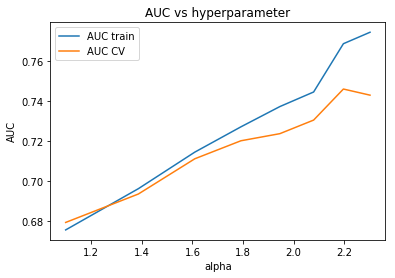

optimal alpha for which auc is maximum :  9


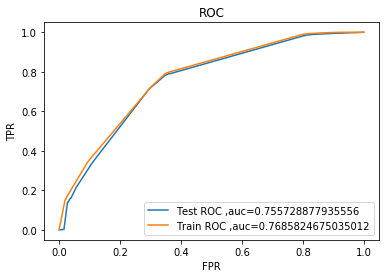

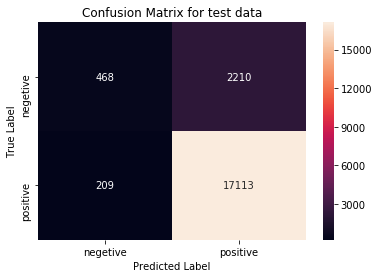

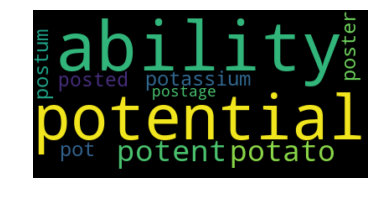

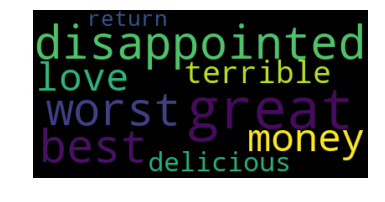

In [114]:
train_test_model(X_train_bow, X_cv_bow, X_test_bow, y_train, y_cv, y_test, count_vect_bow)



### Fit the model on Bigram

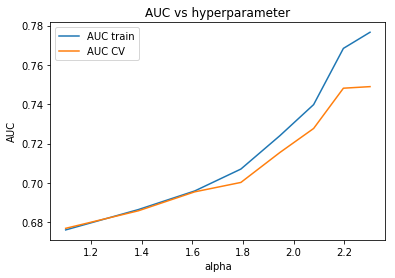

optimal alpha for which auc is maximum :  10


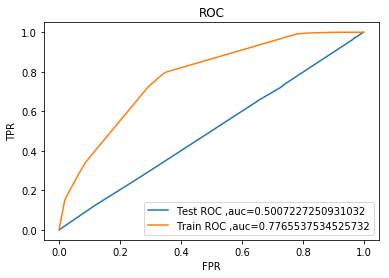

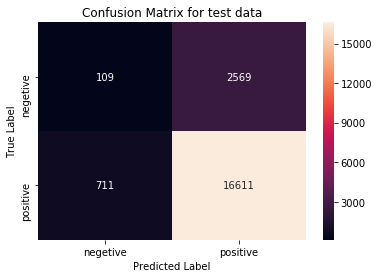

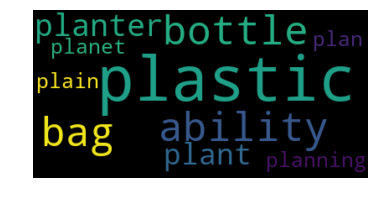

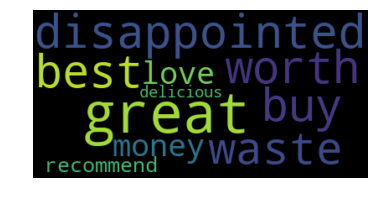

In [115]:
train_test_model(X_train_bigram, X_cv_bigram, X_cv_bigram, y_train, y_cv, y_test, count_vect_bigram)



### Fit the model on tf-idf

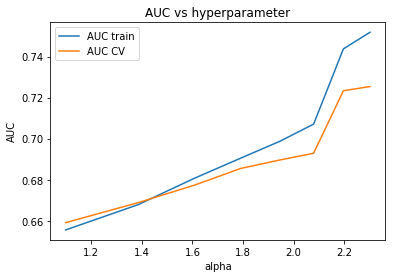

optimal alpha for which auc is maximum :  10


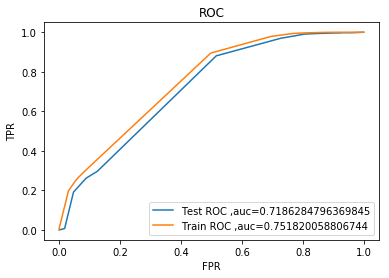

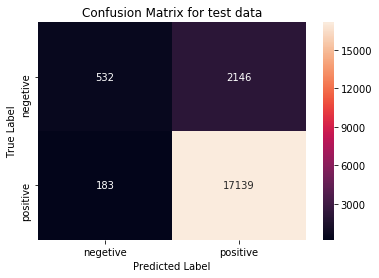

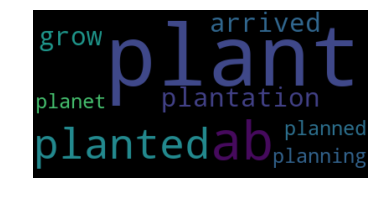

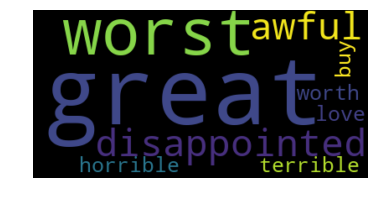

In [116]:
train_test_model(X_train_tfidf, X_cv_tfidf, X_test_tfidf, y_train, y_cv, y_test, tf_idf_vect)



In [117]:
# train_test_model(sent_vectors_train, sent_vectors_cv, sent_vectors_test, y_train, y_cv, y_test, w2v_words)

